In [ ]:
from src.utils.audio import record_with_arecord, stt_pipeline
from src.utils.file_io import read_text, write_text_file
from src.utils.config import *
# DEVICE_PORT, INPUT_FILE, OUTPUT_FILE, ACTIONS_FILE, MEMORY_FILE, HISTORY_FILE, REPLY_FILE

# langggraph_split_files
from src.nodes.langgraph_split_files.actions_schema import ActionDict
from src.nodes.langgraph_split_files.parser_fastpath import parse_fastpath, apply_memory_rules
from src.nodes.langgraph_split_files.parser_gemini import parse_with_gemini
from src.nodes.langgraph_split_files.validator import validate_actions
from src.nodes.langgraph_split_files.hardware_led import setup as led_setup, set_led, cleanup as led_cleanup
from src.nodes.langgraph_split_files.hardware_fan import setup as fan_setup, set_fan, cleanup as fan_cleanup
from src.nodes.langgraph_split_files.hardware_7seg import SevenSegDisplay
from src.nodes.langgraph_split_files.hardware_dht11 import DHT11Reader
import src  # 導入包以訪問 disp

# langgraph modules
from typing import TypedDict, Annotated, List, Dict, Any, Optional # Imports all the data types we need
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
import time

In [ ]:
class AgentState(TypedDict):
    input_text: str                    # 使用者輸入的文字
    raw_actions: List[ActionDict]      # 解析器輸出的原始動作
    validated_actions: List[ActionDict] # 驗證後的動作（可選）
    status: str                        # 當前狀態: "start", "record", "analyzed", "fastpath_parsed", "gemini_parsed", "parse_failed", "executed", "error"
    memory_rules: Dict[str, str]       # 記憶規則（從 parser_fastpath）
    history: Annotated[List[Dict[str, Any]], add_messages]  # 對話歷史
    last_input_time: float             # 最後輸入時間戳
    needs_clarification: bool = False  # 是否需要澄清
    clarification_message: Optional[str] = None  # 澄清訊息
    llm_reply: Optional[str] = None     # Gemini 原始回覆（JSON 字串）
    parse_source: Optional[str] = None  # 解析來源: fastpath/gemini/none
    failure_count: int = 0              # 連續失敗次數
    error_message: Optional[str] = None # 錯誤訊息
    
    # === 從 main.py 新增的字段 ===
    ambient_temp: Optional[int] = None  # 環境溫度
    setpoint_temp: int = 25             # 目標設定溫度
    display_override_until: float = 0.0  # 顯示覆蓋時間
    auto_pause_until: float = 0.0       # 自動控制暫停時間
    auto_fan_state: Optional[str] = None  # 自動風扇狀態
    last_manual_fan_time: float = 0.0   # 上次手動操作時間
'''
def record(state: AgentState) -> AgentState:
    """樹莓派的錄音節點"""
    wav_path = record_with_arecord(duration=4, device=DEVICE_PORT)
    if not wav_path:
        print("record node error")
    state["status"] = "record"
    state["last_input_time"] = time.time()  # 更新時間戳
    return state
'''

def record_analyze(state: AgentState) -> AgentState:
    """whisper.cpp解析.wav檔案並寫入input.txt"""
    text = stt_pipeline(duration=3, device=DEVICE_PORT)

    # 先更新感測器讀值
    if DHT11_ENABLED and hasattr(src, 'dht_reader') and src.dht_reader:
        ambient_temp = src.dht_reader.get_temp_int()
        if ambient_temp is not None:
            state["ambient_temp"] = ambient_temp

    if text and text.strip():
        cleaned_text = text.strip()
        write_text_file(INPUT_FILE, cleaned_text)  # 寫檔
        state["input_text"] = cleaned_text
        state["status"] = "analyzed"
        state["last_input_time"] = time.time()  # 更新時間戳
    else:
        state["input_text"] = ""
        state["needs_clarification"] = True
        state["clarification_message"] = None
        state["status"] = "analyze_error"
    return state

def parse_actions(state: AgentState) -> AgentState:
    """決定用fastpath or gemini_parsed"""
    text = state["input_text"]
    
    if not text:
        state["raw_actions"] = []
        state["status"] = "parse_failed"
        state["parse_source"] = "none"
        state["llm_reply"] = None
        return state

    # 先試 fastpath（記憶 + 快速解析）
    actions = parse_fastpath(text)
    if actions is not None:
        state["raw_actions"] = actions
        state["status"] = "fastpath_parsed"
        state["parse_source"] = "fastpath"
        state["llm_reply"] = None
    else:
        # 再用 gemini，傳遞環境溫度
        current_temp = 25  # 預設目標溫度，可以從狀態中獲取
        if hasattr(src, 'disp') and src.disp:
            current_temp = getattr(src.disp, 'current_temp', 25)

        actions, llm_reply = parse_with_gemini(
            text, return_reply=True, 
            current_temp=current_temp, 
            ambient_temp=ambient_temp # 傳遞環境溫度
        )
        state["llm_reply"] = llm_reply
        state["parse_source"] = "gemini"
        if actions:
            state["raw_actions"] = actions
            state["status"] = "gemini_parsed"
        else:
            state["raw_actions"] = []
            state["status"] = "parse_failed"
        if llm_reply:
            write_text_file(OUTPUT_FILE, llm_reply)

    return state

def validate_actions_node(state: AgentState) -> AgentState:
    """驗證動作合法性"""

    if state.get("status") in ["parse_failed", "analyze_error"]:
        state["validated_actions"] = []
        state["needs_clarification"] = True
        state["clarification_message"] = "抱歉，我無法理解您的指令。請重新說一次，例如：開啟廚房燈。"
        state["status"] = "needs_clarification"
        state["failure_count"] = state.get("failure_count", 0) + 1
        return state

    validated = validate_actions(state["raw_actions"]) #可能為空列表，需返回錄音階段
    state["validated_actions"] = validated
    
    if not validated:  # 如果沒有有效動作
        state["needs_clarification"] = True
        state["clarification_message"] = None
        state["status"] = "needs_clarification"
        state["failure_count"] = state.get("failure_count", 0) + 1
    else:
        state["status"] = "validated"
        state["needs_clarification"] = False
        state["failure_count"] = 0
    
    return state

def direct_action(state: AgentState) -> AgentState:
    """根據動作類型呼叫對應硬件函式"""
    
    for action in state["validated_actions"]:
        action_type = action["type"]
        
        if action_type == "SET_TEMP":
            # 設定溫度 - 呼叫7段顯示器
            temp = action["value"]
            src.disp.set_temp(temp)
            print(f"設定溫度為: {temp}°C")
            
        elif action_type == "FAN":
            # 開關風扇
            fan_state = action["state"]  # "on" 或 "off"
            set_fan(fan_state)
            print(f"風扇: {fan_state}")
            
            # 如果有持續時間，處理定時關閉
            duration = action.get("duration")
            if duration and fan_state == "on":
                # 可以啟動定時器線程來自動關閉
                pass
                
        elif action_type == "LED":
            # 開關LED燈
            location = action["location"]  # "KITCHEN", "LIVING", "GUEST"
            led_state = action["state"]       # "on" 或 "off"
            set_led(location, led_state)
            print(f"{location}燈: {led_state}")
            
            # 如果有持續時間，處理定時關閉
            duration = action.get("duration")
            if duration and led_state == "on":
                # 可以啟動定時器線程來自動關閉
                pass
    
    state["status"] = "executed"
    return state

def init_hardware_node(state: AgentState) -> AgentState:
    """初始化所有硬件"""

    # 7段顯示器
    global disp
    disp = SevenSegDisplay()
    disp.setup()
    disp.start()
    
    # 風扇
    fan_setup()
    
    # LED
    led_setup()
    
    # DHT 溫濕度感測器
    global dht_reader
    try:
        from src.nodes.langgraph_split_files.hardware_dht11 import DHT11Reader
        dht_reader = DHT11Reader()
        dht_reader.start()
        src.dht_reader = dht_reader  # 存儲到 src 模組中
        print("[INFO] DHT11 initialized and started")
    except Exception as e:
        print(f"[WARNING] Failed to initialize DHT11: {e}")
        src.dht_reader = None

    state["status"] = "hardware_initialized"
    return state

def execute_hardware(state: AgentState) -> AgentState:
    """
    執行硬件動作
    硬件已在 main.py 中初始化，這裡只執行動作
    """

    # 獲取環境溫度
    ambient_temp = None
    if hasattr(src, 'dht_reader') and src.dht_reader:
        ambient_temp = src.dht_reader.get_temp_int()

    # 設定溫度變數
    setpoint_temp = 25  # 預設目標溫度

    if not state.get("validated_actions"):
        state["status"] = "no_actions"
        return state
    
    # 執行動作
    errors: List[str] = []
    for action in state["validated_actions"]:
        try:
            if action["type"] == "SET_TEMP":
                if src.disp:
                    temp = action["value"]
                    src.disp.set_temp(temp)
                    setpoint_temp = temp  # 更新目標溫度
                    
                    # 記錄目標溫度到狀態中
                    state["setpoint_temp"] = temp
                else:
                    errors.append("7段顯示器尚未初始化")

            elif action["type"] == "FAN":
                fan_state = action["state"]
                set_fan(fan_state)

                # 如果有持續時間，處理定時關閉
                duration = action.get("duration")
                if duration and fan_state == "on":
                    # 可以啟動定時器線程來自動關閉
                    pass

            elif action["type"] == "LED":
                set_led(action["location"], action["state"])

        except Exception as e:
            errors.append(str(e))
            continue
    
    # 自動冷卻邏輯（可選）
    if ambient_temp is not None and state.get("auto_cool_enabled", False):
        setpoint_temp = state.get("setpoint_temp", 25)
        hyst = 2  # 溫度滯後值
        
        if ambient_temp >= (setpoint_temp + hyst):
            set_fan("on")
    
        elif ambient_temp <= (setpoint_temp - hyst):
            set_fan("off")

    if errors:
        state["status"] = "hardware_error"
        state["error_message"] = "; ".join(errors)
        return state
    
    state["status"] = "executed"
    return state

def cleanup_hardware_node(state: AgentState) -> AgentState:
    """清理所有硬件"""
    try:
        # 清理 DHT11
        if "dht_reader" in globals() and dht_reader:
            dht_reader.stop()
        if hasattr(src, 'dht_reader') and src.dht_reader:
            src.dht_reader.stop()
        if "disp" in globals() and disp:
            disp.cleanup()
        fan_cleanup()
        led_cleanup()
        
    except Exception as e:
        print(f"清理硬件時發生錯誤: {e}")
    
    state["status"] = "cleaned"
    return state

def update_history(state: AgentState) -> AgentState:
    """更新歷史記錄"""
    from src.nodes.langgraph_split_files.parser_fastpath import push_history
    
    # 記錄這輪對話
    user_text = state.get("input_text", "")
    result = {
        "actions": state.get("validated_actions", []),
        "status": state["status"],
        "parse_source": state.get("parse_source"),
        "llm_reply": state.get("llm_reply"),
        "error": state.get("error_message")
    }
    push_history(user_text, result)
    
    state["status"] = "history_updated"
    return state

def check_end(state: AgentState) -> AgentState:
    """檢查是否結束對話的節點"""
    # 檢查超時（例如超過5秒無輸入）
    current_time = time.time()
    last_input = state.get("last_input_time", current_time)
    if current_time - last_input > 5:  # 5秒鐘
        state["status"] = "timeout_end"
        return state

    # 連續失敗保護
    if state.get("failure_count", 0) >= 3:
        state["status"] = "too_many_failures"
        return state
    
    # 檢查用戶是否說了結束詞
    text = state.get("input_text", "").lower()
    if any(word in text for word in ["結束", "停止", "再見", "end", "stop", "bye"]):
        state["status"] = "user_end"
        return state
    
    # 檢查是否需要澄清
    if state.get("needs_clarification", False):
        state["status"] = "needs_clarification"
        return state
    
    state["status"] = "continue"
    return state

def should_end(state: AgentState) -> str:
    """條件函式：決定是否結束"""
    if state.get("status") in ["timeout_end", "user_end", "needs_clarification", "too_many_failures"]:
        return "end"
    return "continue"

def should_execute(state: AgentState) -> str:
    """條件函式：決定是否執行硬體"""
    if state.get("needs_clarification", False):
        return "clarify"
    return "execute"

def clarify_or_continue(state: AgentState) -> AgentState:
    """澄清或繼續"""
    if state.get("needs_clarification", False):
        # 輸出澄清訊息（例如通過 TTS 或寫入文件）
        message = state.get("clarification_message")
        if not message:
            user_text = state.get("input_text", "")
            if any("\u4e00" <= ch <= "\u9fff" for ch in user_text):
                message = "請再說一次，我沒聽清楚。"
            else:
                message = "Please say that again, I didn't catch it."
        if message:
            print(f"澄清訊息: {message}")  # 這裡可以替換為 TTS 或寫入 reply.txt
            write_text_file(REPLY_FILE, message)  # 假設寫入回覆文件
        # 重置標誌
        state["needs_clarification"] = False
        state["clarification_message"] = None
    
    state["status"] = "ready_for_next"
    return state


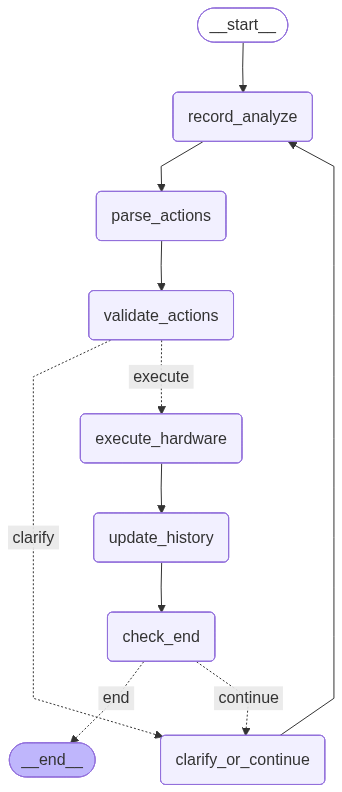

In [4]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))